In [50]:
# f3b8bcb059cc28ebf3b71437d33f956e
# https://fred.stlouisfed.org/docs/api/fred/
# jupyter nbconvert --to script your_notebook.ipynb

# For best practices:

# Use .gitignore to exclude unnecessary files like .ipynb_checkpoints.
# Avoid committing your API key directly to the repository. Store it in an environment variable or a .env file for security.

! pip install fredapi pandas matplotlib requests seaborn imblearn xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 435.7 kB/s eta 0:05:45
   ---------------------------------------- 0.1/150.0 MB 1.1 MB/s eta 0:02:18
   ---------------------------------------- 0.6/150.0 MB 3.9 MB/s eta 0:00:38
   ---------------------------------------- 1.1/150.0 MB 5.8 MB/s eta 0:00:26
   ---------------------------------------- 1.6/150.0 MB 6.9 MB/s eta 0:00:22
    --------------------------------------- 2.2/150.0 MB 7.9 MB/s eta 0:00:19
    --------------------------------------- 2.8/150.0 MB 8.5 MB/s eta 0:00:18
    --------------------------------------- 3.3/150.0 MB 8.9 MB/s eta 0:00:17
   - -------------------------------------- 3.9/150.0 MB 9.1 MB/s eta 0:00:17
   - -------------------------------------- 4.5/150.0 MB 9.5 MB/s eta 0:00:16
   - -------------------------------------- 5.3/150.0 MB 10.3 MB/s eta 0:00:


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\wongd\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [55]:
import os
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import requests
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb

In [ ]:
# PART 1
# FRED API Key
API_KEY = "f3b8bcb059cc28ebf3b71437d33f956e"

# Function to fetch Treasury yield data
def fetch_fred_yield(series_id, start_date="2023-01-01", end_date="2023-12-31", api_key=API_KEY):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date
    }

    # Make API request
    response = requests.get(url, params=params)
    data = response.json()

    # Convert to DataFrame
    observations = data['observations']
    df = pd.DataFrame(observations)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Convert 'value' column to numeric
    df['value'] = pd.to_numeric(df['value'], errors='coerce')

    # Rename column
    df.rename(columns={'value': series_id}, inplace=True)

    return df[[series_id]]

# List of Treasury yield series IDs
tenor_series_ids = [
    "DGS1MO", "DGS3MO", "DGS6MO", "DGS1", 
    "DGS2", "DGS3", "DGS5", "DGS7", 
    "DGS10", "DGS20", "DGS30"
]

# Fetch data for all tenors and combine into one DataFrame
yield_data = pd.concat(
    [fetch_fred_yield(tenor) for tenor in tenor_series_ids],
    axis=1
)

# Save data for reference
yield_data.to_csv('treasury_yields.csv')

print(f"Data successfully retrieved with {yield_data.shape[0]} rows.")
yield_data.head()

Data successfully retrieved with 260 rows.


,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
date,,,,,,,,,,,
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,4.17,4.53,4.77,4.72,4.40,4.18,3.94,3.89,3.79,4.06,3.88
2023-01-04,4.20,4.55,4.77,4.71,4.36,4.11,3.85,3.79,3.69,3.97,3.81
2023-01-05,4.30,4.66,4.81,4.78,4.45,4.18,3.90,3.82,3.71,3.96,3.78
2023-01-06,4.32,4.67,4.79,4.71,4.24,3.96,3.69,3.63,3.55,3.84,3.67


In [20]:
# Load bond yield data
bond_data_path = r"C:\Users\wongd\OneDrive\Desktop\Int\Oak Tree Capital\Code-Assessment\Coding-Assess-main\data\Part 1. bonds_yields.xlsx"
bond_data = pd.read_excel(bond_data_path)
bond_data.columns = bond_data.columns.str.strip().str.replace(' ', '_')
bond_data.head()

,Bond_ID,WAL_(years),Yield_(%),Sector
0,Bond A,1.0,8.63,Telecommunication
1,Bond B,1.5,7.95,Consumer Staples
2,Bond C,2.2,7.53,Utilities
3,Bond D,3.0,7.71,Financials
4,Bond E,4.0,8.45,Telecommunication


In [24]:
def calculate_spread(bond_data, yield_data):
    spreads = []
    
    for _, row in bond_data.iterrows():
        bond_wal = row['WAL_(years)']  # Corrected column name
        bond_yield = row['Yield_(%)']  # Corrected column name

        # Treasury tenors in years
        tenor_years = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
        treasury_values = yield_data.iloc[-1].values

        # Interpolation
        interpolator = interp1d(tenor_years, treasury_values, kind='linear', fill_value='extrapolate')
        interpolated_yield = interpolator(bond_wal)

        # Spread Calculation
        spread = bond_yield - interpolated_yield
        spreads.append(spread)
    
    bond_data['Spread'] = spreads
    return bond_data

# Calculate spreads
bond_data = calculate_spread(bond_data, yield_data)

# Save result
bond_data.to_csv("bond_spread_data.csv", index=False)
bond_data.head()

,Bond_ID,WAL_(years),Yield_(%),Sector,Spread
0,Bond A,1.0,8.63,Telecommunication,3.840
1,Bond B,1.5,7.95,Consumer Staples,3.440
2,Bond C,2.2,7.53,Utilities,3.344
3,Bond D,3.0,7.71,Financials,3.700
4,Bond E,4.0,8.45,Telecommunication,4.525


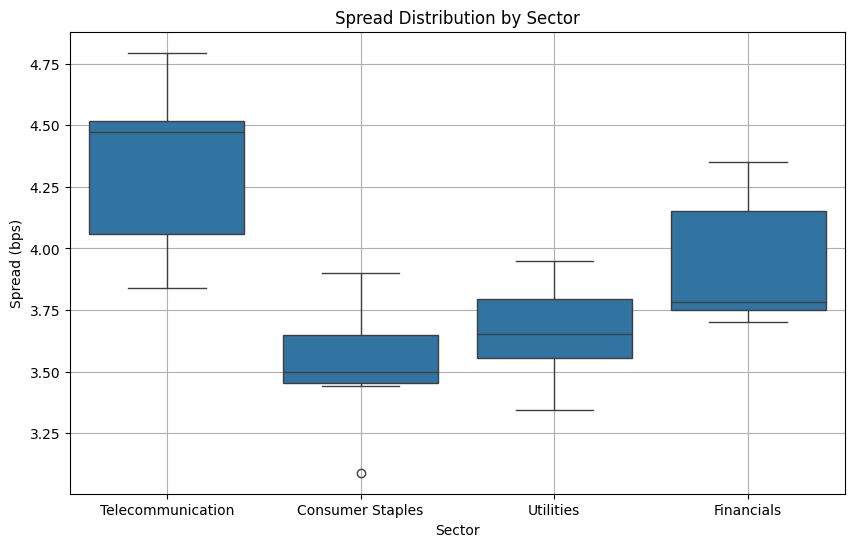

In [ ]:
# Spread Distribution by Sector

plt.figure(figsize=(10, 6))
sns.boxplot(x='Sector', y='Spread', data=bond_data)
plt.title('Spread Distribution by Sector')
plt.xlabel('Sector')
plt.ylabel('Spread (bps)')
plt.grid(True)
plt.show()

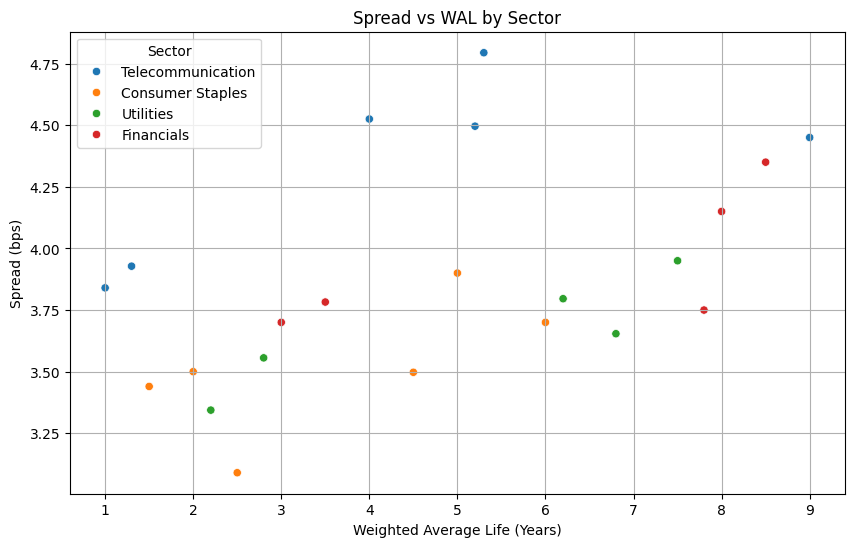

In [31]:
# Spread vs WAL (Weighted Avg Life)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='WAL_(years)', y='Spread', hue='Sector', data=bond_data)
plt.title('Spread vs WAL by Sector')
plt.xlabel('Weighted Average Life (Years)')
plt.ylabel('Spread (bps)')
plt.grid(True)
plt.legend(title='Sector')
plt.show()

In [ ]:
# PART 2
# Load the data
file_path = r"C:\Users\wongd\OneDrive\Desktop\Int\Oak Tree Capital\Code-Assessment\Coding-Assess-main\data\Part 2. loan_data_final.csv"
loan_data = pd.read_csv(file_path)

# Preview the data
print("Data Overview:")
print(loan_data.info())

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      45000 non-null  int64  
 1   person_age                      45000 non-null  int64  
 2   person_gender                   45000 non-null  object 
 3   person_education                45000 non-null  object 
 4   person_income                   45000 non-null  int64  
 5   person_emp_exp                  45000 non-null  int64  
 6   person_home_ownership           45000 non-null  object 
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  int64  
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_def

In [ ]:
# Data Cleaning and Feature Engineering

# Clean column names
loan_data.columns = loan_data.columns.str.strip().str.lower().str.replace(' ', '_')

# Handling missing values
missing_values = loan_data.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# Fill missing values - Example strategies
loan_data['person_income'].fillna(loan_data['person_income'].median(), inplace=True)
loan_data['person_emp_exp'].fillna(loan_data['person_emp_exp'].median(), inplace=True)
loan_data['person_education'].fillna('Unknown', inplace=True)

# Fill missing credit score with median
loan_data['credit_score'].fillna(loan_data['credit_score'].median(), inplace=True)

# Confirm missing data is handled
print("\nMissing Data After Handling:\n", loan_data.isnull().sum().sum())

# === Feature Engineering ===

# 1. Income Stability (Stable Income: 1 if emp_exp >= 5 years)
loan_data['income_stability'] = np.where(loan_data['person_emp_exp'] >= 5, 1, 0)

# 2. Credit Score Binning
loan_data['credit_score_bin'] = pd.cut(
    loan_data['credit_score'], 
    bins=[300, 580, 670, 740, 800, 850], 
    labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
)

# 3. Interest Rate Stress Feature
iqr = loan_data['loan_int_rate'].quantile(0.75) - loan_data['loan_int_rate'].quantile(0.25)
loan_data['int_rate_stress'] = np.where(
    loan_data['loan_int_rate'] > loan_data['loan_int_rate'].median() + 2 * iqr, 1, 0
)

# Feature interaction example
loan_data['int_rate_x_credit_score'] = loan_data['loan_int_rate'] * loan_data['credit_score']
loan_data['risk_score_x_income'] = loan_data['borrower_risk_score'] * loan_data['person_income']
loan_data['loan_to_income_x_unemployment'] = loan_data['loan_to_income_ratio'] * loan_data['regional_unemployment_rate']

# 4. Encode new categorical feature
loan_data = pd.get_dummies(loan_data, columns=['credit_score_bin'], drop_first=True)

# Refine features for better precision
loan_data['int_rate_x_credit_score_high_risk'] = np.where(
    loan_data['int_rate_x_credit_score'] > loan_data['int_rate_x_credit_score'].quantile(0.75), 1, 0
)

loan_data['loan_to_income_x_unemployment_high_risk'] = np.where(
    loan_data['loan_to_income_x_unemployment'] > loan_data['loan_to_income_x_unemployment'].quantile(0.75), 1, 0
)

# Drop 'unnamed:_0' column if it exists
if 'unnamed:_0' in loan_data.columns:
    loan_data.drop('unnamed:_0', axis=1, inplace=True)

loan_data.head()

Missing Values:
 Series([], dtype: int64)

Missing Data After Handling:
 0


C:\Users\wongd\AppData\Local\Temp\ipykernel_9024\3194720034.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data['person_income'].fillna(loan_data['person_income'].median(), inplace=True)
C:\Users\wongd\AppData\Local\Temp\ipykernel_9024\3194720034.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_to_income_ratio,loan_type,dependents_count,regional_unemployment_rate,borrower_risk_score,loan_status,income_stability,int_rate_stress,int_rate_x_credit_score,risk_score_x_income,loan_to_income_x_unemployment,credit_score_bin_Fair,credit_score_bin_Good,credit_score_bin_Very Good,credit_score_bin_Excellent,int_rate_x_credit_score_high_risk,loan_to_income_x_unemployment_high_risk
0,22,female,Master,71948,0,RENT,PERSONAL,16.02,0.49,3,561,No,0.49,FLOATING,3,6.84,281.4,1,0,0,8987.22,20246167.2,3.3516,False,False,False,False,1,1
1,21,female,High School,12282,0,OWN,EDUCATION,11.14,0.08,2,504,Yes,0.08,FIXED,0,5.96,252.4,0,0,0,5614.56,3099976.8,0.4768,False,False,False,False,0,0
2,25,female,High School,12438,3,MORTGAGE,MEDICAL,12.87,0.44,3,635,No,0.44,FIXED,0,6.69,318.4,1,0,0,8172.45,3960259.2,2.9436,True,False,False,False,0,1
3,23,female,Bachelor,79753,0,RENT,MEDICAL,15.23,0.44,2,675,No,0.44,FIXED,3,7.63,338.1,1,0,0,10280.25,26964489.3,3.3572,False,True,False,False,1,1
4,24,male,Master,66135,1,RENT,MEDICAL,14.27,0.53,4,586,No,0.53,FLOATING,0,4.63,294.2,1,0,0,8362.22,19456917.0,2.4539,True,False,False,False,1,1


In [ ]:
# Encode categorical variables
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership', 
                    'loan_intent', 'loan_type', 'previous_loan_defaults_on_file']

loan_data = pd.get_dummies(loan_data, columns=categorical_cols, drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
num_cols = ['person_income', 'person_emp_exp', 'loan_int_rate', 
            'loan_percent_income', 'cb_person_cred_hist_length', 
            'credit_score', 'loan_to_income_ratio', 'regional_unemployment_rate']

loan_data[num_cols] = scaler.fit_transform(loan_data[num_cols])

✅ Accuracy Score: 0.9233333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     10493
           1       0.88      0.76      0.82      3007

    accuracy                           0.92     13500
   macro avg       0.91      0.87      0.88     13500
weighted avg       0.92      0.92      0.92     13500



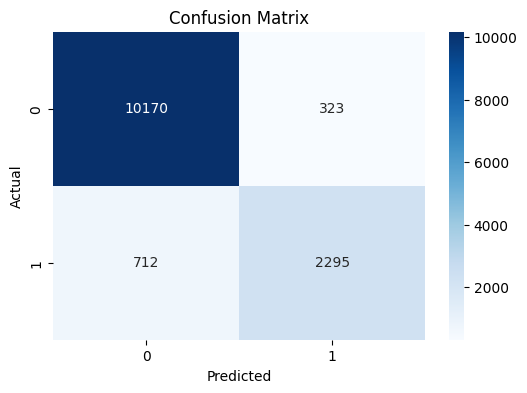

In [91]:
# Define target and features
X = loan_data.drop('loan_status', axis=1)  # Assuming 'loan_status' is the target column
y = loan_data['loan_status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation Metrics
print("✅ Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# RandomForest with Class Weights
rf_weighted = RandomForestClassifier(n_estimators=100, class_weight={0: 1, 1: 2}, random_state=42)
rf_weighted.fit(X_train, y_train)

y_pred_rf_weighted = rf_weighted.predict(X_test)
print("RandomForest (Weighted) Performance:")
print(classification_report(y_test, y_pred_rf_weighted))

RandomForest (Weighted) Performance:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10493
           1       0.88      0.75      0.81      3007

    accuracy                           0.92     13500
   macro avg       0.91      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500



In [93]:
from imblearn.over_sampling import SMOTE

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train RandomForest with SMOTE
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = rf_smote.predict(X_test)
print("RandomForest (SMOTE) Performance:")
print(classification_report(y_test, y_pred_smote))

RandomForest (SMOTE) Performance:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     10493
           1       0.79      0.82      0.80      3007

    accuracy                           0.91     13500
   macro avg       0.87      0.88      0.87     13500
weighted avg       0.91      0.91      0.91     13500



In [94]:
from xgboost import XGBClassifier

# XGBoost with Class Weight Scaling
xgb_model = XGBClassifier(scale_pos_weight=5, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     10493
           1       0.72      0.91      0.81      3007

    accuracy                           0.90     13500
   macro avg       0.85      0.90      0.87     13500
weighted avg       0.92      0.90      0.91     13500



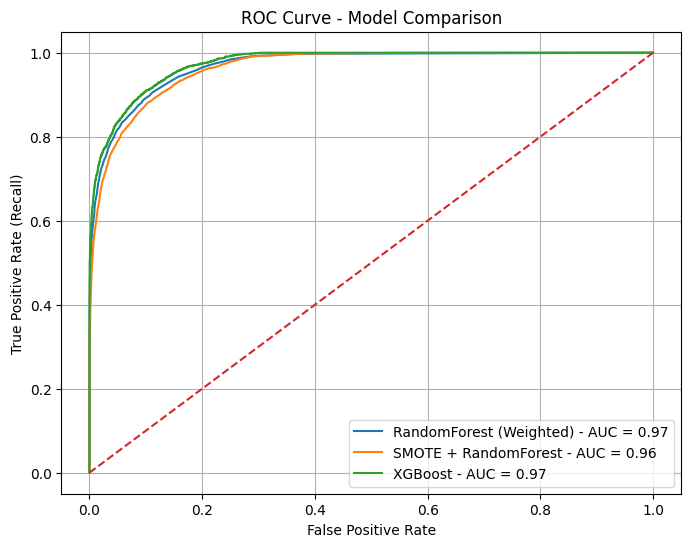

In [95]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# RandomForest Weighted
y_probs_rf = rf_weighted.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
plt.plot(fpr_rf, tpr_rf, label='RandomForest (Weighted) - AUC = {:.2f}'.format(auc(fpr_rf, tpr_rf)))

# SMOTE + RandomForest
y_probs_smote = rf_smote.predict_proba(X_test)[:, 1]
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_probs_smote)
plt.plot(fpr_smote, tpr_smote, label='SMOTE + RandomForest - AUC = {:.2f}'.format(auc(fpr_smote, tpr_smote)))

# XGBoost
y_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_xgb)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost - AUC = {:.2f}'.format(auc(fpr_xgb, tpr_xgb)))

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Model Comparison')
plt.legend()
plt.grid(True)
plt.show()

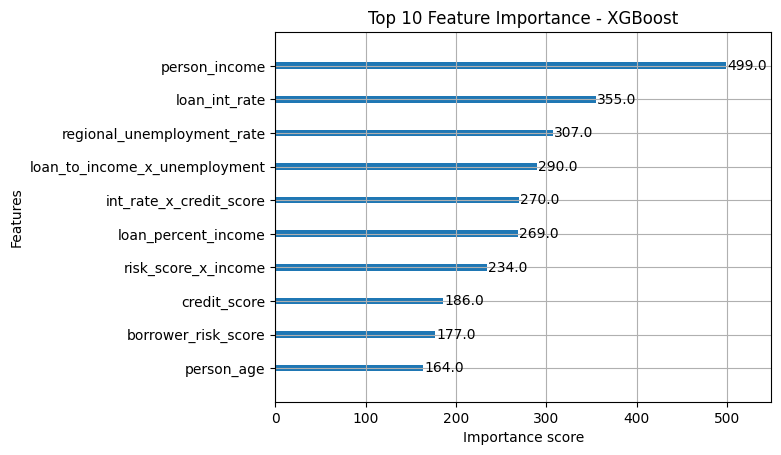

In [96]:
# Plot Feature Importance
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title('Top 10 Feature Importance - XGBoost')
plt.show()

In [97]:
# Extract feature importance from XGB
xgb_importance = xgb_model.get_booster().get_score(importance_type='weight')

# Convert to DataFrame
importance_df = pd.DataFrame.from_dict(xgb_importance, orient='index', columns=['Importance']).reset_index()
importance_df.rename(columns={'index': 'Feature'}, inplace=True)

# Sort by importance (highest first)
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display top 10 most important features
print("Top 10 Important Features:")
print(importance_df.head(10))

# Save for further analysis
importance_df.to_csv('xgboost_feature_importance.csv', index=False)

Top 10 Important Features:
                          Feature  Importance
1                   person_income       499.0
3                   loan_int_rate       355.0
9      regional_unemployment_rate       307.0
13  loan_to_income_x_unemployment       290.0
11        int_rate_x_credit_score       270.0
4             loan_percent_income       269.0
12            risk_score_x_income       234.0
6                    credit_score       186.0
10            borrower_risk_score       177.0
0                      person_age       164.0


In [99]:
# Extract feature names directly from the trained XGBoost model
xgb_features = xgb_model.get_booster().feature_names
print("✅ Features expected by XGBoost:\n", xgb_features)

# Align training and test data to match XGBoost's feature set
X_train_aligned = X_train[xgb_features]
X_test_aligned = X_test[xgb_features]

# Confirm alignment
print(f"✅ Aligned Features Match: {set(X_train_aligned.columns) == set(xgb_features)}")

from sklearn.metrics import precision_recall_curve

# Predict probabilities
y_probs = xgb_model.predict_proba(X_test_aligned)[:, 1]

# Tune threshold for precision focus
threshold = 0.6
y_pred_adjusted = (y_probs >= threshold).astype(int)

# Evaluate threshold-adjusted model
print("✅ Threshold-Adjusted XGBoost Performance:")
print(classification_report(y_test, y_pred_adjusted))

✅ Features expected by XGBoost:
 ['person_age', 'person_income', 'person_emp_exp', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_to_income_ratio', 'dependents_count', 'regional_unemployment_rate', 'borrower_risk_score', 'income_stability', 'int_rate_stress', 'int_rate_x_credit_score', 'risk_score_x_income', 'loan_to_income_x_unemployment', 'credit_score_bin_Fair', 'credit_score_bin_Good', 'credit_score_bin_Very Good', 'credit_score_bin_Excellent', 'int_rate_x_credit_score_high_risk', 'loan_to_income_x_unemployment_high_risk', 'person_gender_male', 'person_education_Bachelor', 'person_education_Doctorate', 'person_education_High School', 'person_education_Master', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_type_FLOATING', 'previous_loan_defaults_on_file_Yes']
✅ Alig

Decided to stick with XG Boost rather than Random Forest as having a higher recall makes more sense than precision, I think the better balanced model is XG Boost and with some adjustments you can improve the model precision (feature engineering and tuning thresholds). With the Random Forest model, you run the risk of incorrectly predicting default risk (false positives, poorer at capturing true defaults).